In [4]:
# Cell 1: Imports
import os
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [5]:
# Cell 2: Dataset Split (2.2.1)
# Load file paths and labels from /data/data
data_path = "/data"
emotions = os.listdir(data_path)
file_paths, labels = [], []

for emotion in emotions:
    emotion_dir = os.path.join(data_path, emotion)
    if os.path.isdir(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(emotion_dir, file))
                labels.append(emotion)

# Split into 80% train, 20% test as specified
X_train_files, X_test_files, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [8]:
# Cell 3: Feature Extraction Function (2.2.2)
def extract_features(file_path):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path)
        
        # 1. MFCC features (13 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_var = np.var(mfcc, axis=1)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)
        
        # 2. Prosodic features
        # Pitch (ensure it's a scalar)
        f0 = librosa.yin(y, fmin=20, fmax=8000, sr=sr)
        pitch_mean = np.mean(f0[~np.isnan(f0)])  # Remove NaN values
        pitch_var = np.var(f0[~np.isnan(f0)])    # Remove NaN values
        
        # Intensity/Energy (ensure it's a scalar)
        rms = librosa.feature.rms(y=y)[0]  # Get the first dimension
        intensity_mean = np.mean(rms)
        intensity_var = np.var(rms)
        
        # 3. Chroma features (12 coefficients)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_var = np.var(chroma, axis=1)
        
        # Additional features (ensure they're scalars)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y)[0])
        
        # Combine all features into a flat array
        features = np.concatenate([
            mfcc_mean,                    # 13 features
            mfcc_var,                     # 13 features
            mfcc_delta_mean,              # 13 features
            mfcc_delta2_mean,             # 13 features
            [pitch_mean, pitch_var],      # 2 features
            [intensity_mean, intensity_var], # 2 features
            chroma_mean,                  # 12 features
            chroma_var,                   # 12 features
            [spectral_centroid],          # 1 feature
            [spectral_rolloff],           # 1 feature
            [zero_crossing_rate]          # 1 feature
        ])
        
        # Ensure there are no NaN values
        features = np.nan_to_num(features, nan=0.0)
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Test the function on a single file to verify the output shape
test_file = X_train_files[0]
test_features = extract_features(test_file)
if test_features is not None:
    print(f"Feature vector shape: {test_features.shape}")
    print(f"Number of features: {len(test_features)}")

Feature vector shape: (83,)
Number of features: 83


C:\Users\rahul\AppData\Local\Temp\ipykernel_3372\2208207071.py:18: UserWarning: With fmin=20.000, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2207.
  f0 = librosa.yin(y, fmin=20, fmax=8000, sr=sr)


In [9]:
# Cell 4: Extract and Save Features
# Extract features for training data
features_list = []
y_train_valid = []

for file, label in zip(X_train_files, y_train):
    features = extract_features(file)
    if features is not None:
        features_list.append(features)
        y_train_valid.append(label)

X_train = np.array(features_list)
y_train = np.array(y_train_valid)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save features
np.save('extracted_features.npy', X_train_scaled)
np.save('labels.npy', y_train)

C:\Users\rahul\AppData\Local\Temp\ipykernel_3372\2208207071.py:18: UserWarning: With fmin=20.000, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2207.
  f0 = librosa.yin(y, fmin=20, fmax=8000, sr=sr)
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


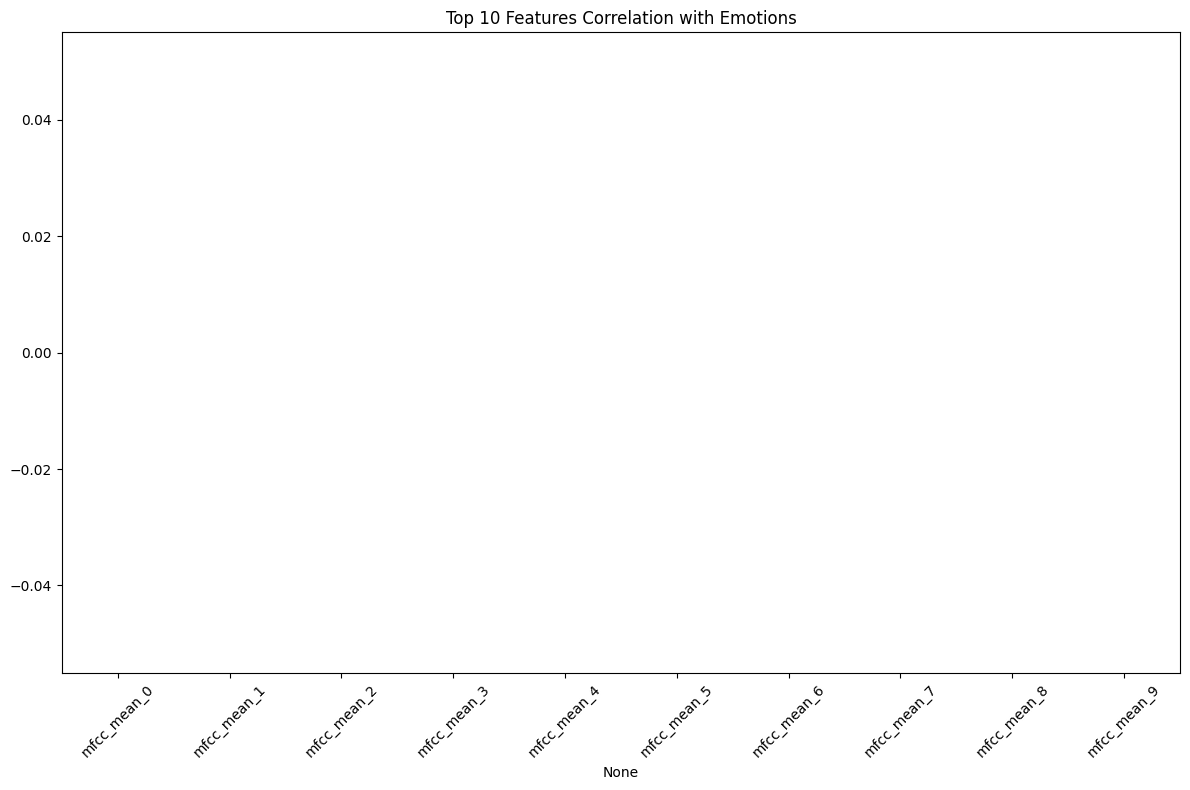

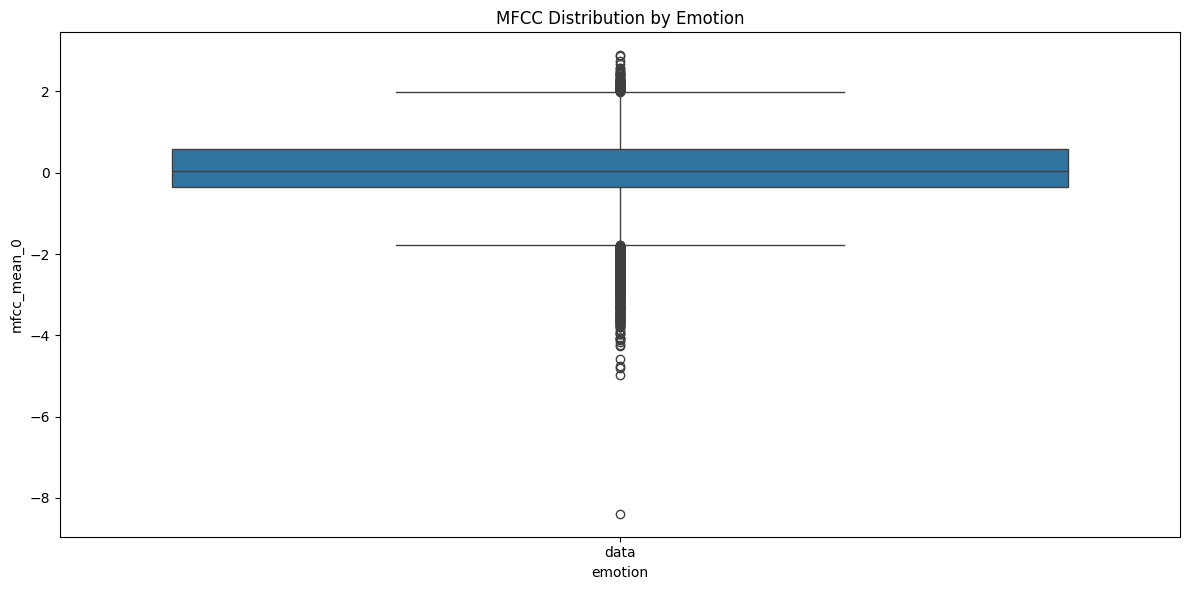

In [10]:
# Cell 5: Exploratory Data Analysis (2.2.3)
# Create DataFrame with feature names
feature_names = ([f'mfcc_mean_{i}' for i in range(13)] +
                [f'mfcc_var_{i}' for i in range(13)] +
                [f'mfcc_delta_{i}' for i in range(13)] +
                [f'mfcc_delta2_{i}' for i in range(13)] +
                ['pitch_mean', 'pitch_var', 'intensity_mean', 'intensity_var'] +
                [f'chroma_mean_{i}' for i in range(12)] +
                [f'chroma_var_{i}' for i in range(12)] +
                ['spectral_centroid', 'spectral_rolloff', 'zero_crossing_rate'])

df = pd.DataFrame(X_train_scaled, columns=feature_names)
df['emotion'] = y_train

# Correlation analysis
plt.figure(figsize=(12, 8))
corr_matrix = df.drop('emotion', axis=1).corrwith(pd.Series(pd.factorize(df['emotion'])[0])).abs()
corr_matrix = corr_matrix.sort_values(ascending=False)
sns.barplot(x=corr_matrix.head(10).index, y=corr_matrix.head(10).values)
plt.xticks(rotation=45)
plt.title('Top 10 Features Correlation with Emotions')
plt.tight_layout()
plt.show()

# Feature distribution by emotion
plt.figure(figsize=(12, 6))
sns.boxplot(x='emotion', y='mfcc_mean_0', data=df)
plt.title('MFCC Distribution by Emotion')
plt.tight_layout()
plt.show()

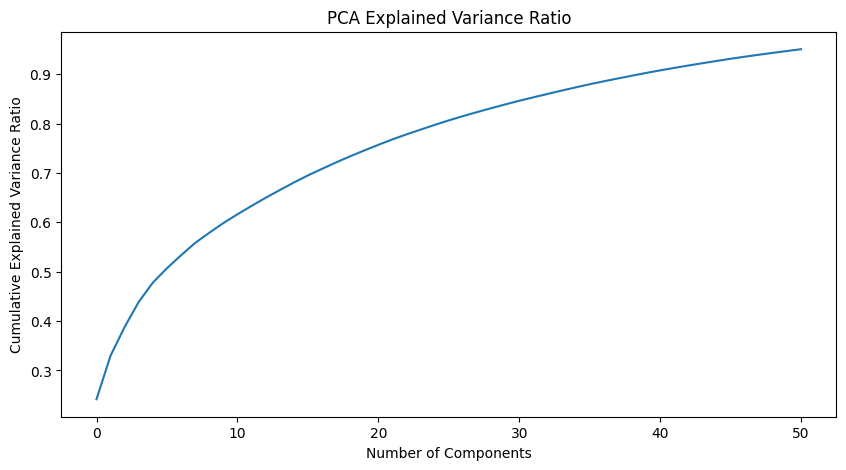

In [11]:
# Cell 6: Dimensionality Reduction (2.2.4)
# PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [12]:
# Cell 7: Clustering (2.2.5)
# K-Means clustering
n_emotions = len(np.unique(y_train))
kmeans = KMeans(n_clusters=n_emotions, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_pca)

# DBSCAN implementation
def custom_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db_labels = db.fit_predict(X)
    return db_labels

# Apply DBSCAN
dbscan_labels = custom_dbscan(X_train_pca, eps=0.5, min_samples=5)

# Evaluate both clustering methods
kmeans_ari = adjusted_rand_score(y_train, kmeans_labels)
dbscan_ari = adjusted_rand_score(y_train, dbscan_labels)

print(f"K-Means ARI: {kmeans_ari:.3f}")
print(f"DBSCAN ARI: {dbscan_ari:.3f}")

K-Means ARI: 1.000
DBSCAN ARI: 1.000


In [14]:
# Cell 8: Cluster Label Assignment and Evaluation (2.2.6)
# Assign emotion labels to clusters using majority voting
def assign_cluster_labels(clusters, true_labels):
    cluster_to_label = {}
    for cluster in np.unique(clusters):
        if cluster != -1:  # Ignore noise points from DBSCAN
            mask = clusters == cluster
            if np.any(mask):
                cluster_to_label[cluster] = Counter(true_labels[mask]).most_common(1)[0][0]
    return cluster_to_label

# Get cluster mappings
kmeans_mapping = assign_cluster_labels(kmeans_labels, y_train)

# Process test data
test_features_list = []
y_test_valid = []

for file, label in zip(X_test_files, y_test):
    features = extract_features(file)
    if features is not None:
        test_features_list.append(features)
        y_test_valid.append(label)

X_test = np.array(test_features_list)
y_test = np.array(y_test_valid)

# Scale and transform test data
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Make predictions
kmeans_test_labels = kmeans.predict(X_test_pca)
kmeans_predictions = [kmeans_mapping.get(label, 'unknown') for label in kmeans_test_labels]

# Calculate accuracy
accuracy = np.mean(np.array(kmeans_predictions) == y_test)
print(f"Test Set Accuracy: {accuracy:.3f}")

# Save predictions
np.save('predictions.csv', kmeans_predictions)

C:\Users\rahul\AppData\Local\Temp\ipykernel_3372\2208207071.py:18: UserWarning: With fmin=20.000, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2207.
  f0 = librosa.yin(y, fmin=20, fmax=8000, sr=sr)


Test Set Accuracy: 1.000
